# Training a MNIST classifier

This tutorial introduces the [norse](norse.ai) library by going through the "Hello World" of deep-learning: How to classify hand-written digits. Norse is based on the popular pytorch deep-learning library and this is in fact the only requirement you need to build your own models with it.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

It can be installed directly from its github repository, which for now is the recommended way of using the library, since it still is changing rather quickly.

In [2]:
!pip install -qU git+https://github.com/norse/norse

You should consider upgrading via the '/home/jens/.venvs/norse/bin/python3 -m pip install --upgrade pip' command.


## Integrating point neuron model equations

Spiking neuron models are given as (typically very simple) systems of ordinary differential
equations. A common example used is the so called current based leaky integrate and fire neuron model (LIF). Its differential equation is given by
\begin{align*}
\dot{v} &= -(v - v_\text{reset}) + I \\
\dot{I} &= -I + I_\text{in}
\end{align*}
together with jump and transition equations, that specify when a jump occurs and
how the state variables change. A prototypical equation is a leaky integrator
with constant current input $I_\text{in}$, with jump condition $v - 1 = 0$ and transition equation $v^+ - v^- = -1$.


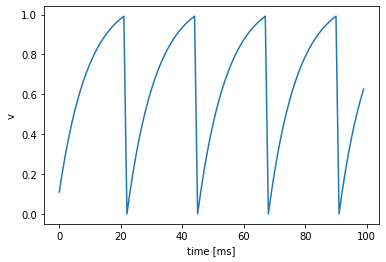

In [3]:
from norse.torch.functional.lif import lif_step, lif_feed_forward_step, lif_current_encoder, LIFParameters

N = 1 # number of neurons to consider
T = 100 # number of timesteps to integrate

p = LIFParameters()
v = torch.zeros(N) # initial membrane voltage
input_current = 1.1 * torch.ones(N)

voltages = []

for ts in range(T):
  z, v = lif_current_encoder(input_current, v, p)
  voltages.append(v)

voltages = torch.stack(voltages)

plt.ylabel("v")
plt.xlabel("time [ms]")
plt.plot(voltages)
plt.show()

## MNIST dataset

A common toy dataset to test machine learning approaches on is the MNIST handwritten digit recognition dataset. The goal is to distinguish handwritten digits 0..9 based on a 28x28 grayscale picture.

In [4]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE
)

## Encoding Input Data

One of the distinguishing features of spiking neural networks is that they
operate on temporal data encoded as spikes. Common datasets in machine learning
of course don't use such an encoding and therefore make a encoding step necessary. Here we choose to treat the grayscale value of an MNIST image
as a constant current to produce input spikes to the rest of the network.
Another option would be to interpret the grayscale value as a spike probabilty
at each timestep.


### Constant Current Encoder

In [5]:
from norse.torch.module.encode import ConstantCurrentLIFEncoder

We can easily visualise the effect of this choice of encoding on a sample image in the training data set

0


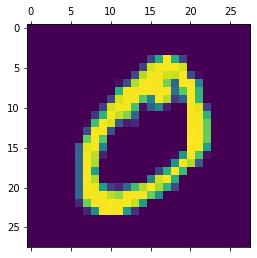

In [6]:
img, label = train_data[1]

plt.matshow(img[0])
print(label)

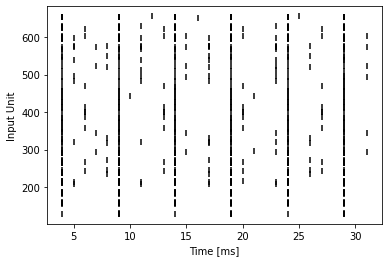

In [7]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T,28*28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

### Poisson Encoding

As can be seen from the spike raster plot, this kind of encoding does not produce spike patterns which are necessarily biologically realistic. We could rectify this situation by employing cells with varying threshholds and a finer integration time step. Alternatively we can encode the grayscale input images into poisson spike trains




In [8]:
from norse.torch.module.encode import PoissonEncoder

This produces a more biological plausible input pattern, as can be seen below:

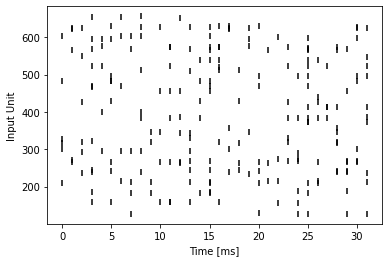

In [9]:
T = 32
example_encoder = PoissonEncoder(T, f_max=20)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T,28*28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

### Spike Latency Encoding

Yet another example is a spike latency encoder. In this case each input neuron spikes only once, the first time the input crosses the threshhold.

In [10]:
from norse.torch.module.encode import SpikeLatencyLIFEncoder

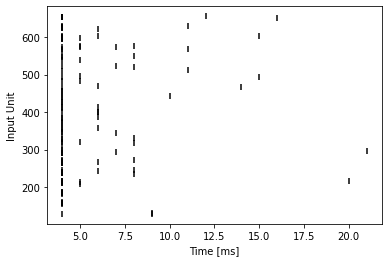

In [11]:
T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T,28*28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

## Defining a Network

Once the data is encoded into spikes, a spiking neural network can be constructed in the same way as a one would construct a recurrent neural network.
Here we define a spiking neural network with one recurrently connected layer
with `hidden_features` LIF neurons and a readout layer with `output_features` and leaky-integrators. As you can see, we can freely combine spiking neural network primitives with ordinary `torch.nn.Module` layers.

In [12]:
from norse.torch.module.lif import LIFCell, LIFParameters, LIFFeedForwardCell
from norse.torch.module.leaky_integrator import LIFeedForwardCell

from norse.torch.functional.lif import LIFState
from norse.torch.functional.leaky_integrator import LIState

from typing import NamedTuple

class SNNState(NamedTuple):
    lif0 : LIFState
    readout : LIState


class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, record=False, dt=0.001):
        super(SNN, self).__init__()
        self.l1 = LIFCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=0.5),
            dt=dt                     
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LIFeedForwardCell(shape=(output_features,), dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record
        

        
    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = self.l1.initial_state(batch_size, x.device, torch.float)
        so = self.out.initial_state(batch_size, x.device)
        voltages = []

        if self.record:
          self.recording = SNNState(
              LIFState(
                z = torch.zeros(seq_length, batch_size, self.hidden_features),
                v = torch.zeros(seq_length, batch_size, self.hidden_features),
                i = torch.zeros(seq_length, batch_size, self.hidden_features)
              ),
              LIState(
                v = torch.zeros(seq_length, batch_size, self.output_features),
                i = torch.zeros(seq_length, batch_size, self.output_features)
              )
          )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
              self.recording.lif0.z[ts,:] = s1.z
              self.recording.lif0.v[ts,:] = s1.v
              self.recording.lif0.i[ts,:] = s1.i
              self.recording.readout.v[ts,:] = so.v
              self.recording.readout.i[ts,:] = so.i
            voltages += [vo]

        return torch.stack(voltages)

We can visualize the output produced by the recurrent spiking neural network on the example input.

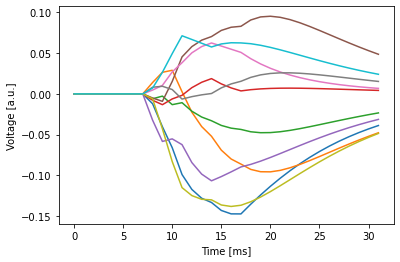

In [13]:
example_snn = SNN(28*28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
plt.plot(example_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

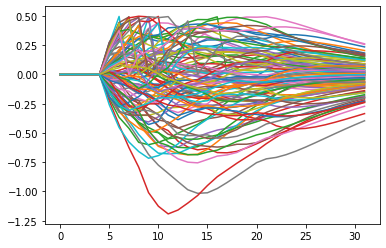

In [14]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

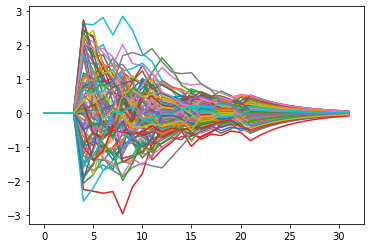

In [15]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

## Decoding the Output

The output of the network we have defined are $10$ membrane voltage traces. What remains to do is to interpret those as a probabilty distribution. One way of doing so is to determine the maximum along the time dimension and to then compute the softmax of these values. There are other options of course, for example to consider
the average membrane voltage in a given time window or use a LIF neuron output layer and consider the time to first spike.

In [16]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

An alternative way of decoding would be to consider only the membrane trace at the last measured time step.

In [17]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

## Training the Network

The final model is then simply the sequential composition of these three steps: Encoding, a spiking neural network and decoding.

In [18]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

We can then instantiate the model with the recurrent ```SNN``` network defined above.

In [19]:
T = 32
DEVICE = torch.device("cuda")
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

model = Model(
    encoder=ConstantCurrentLIFEncoder(
      seq_length=T,
    ),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SNN(
    (l1): LIFCell(784, 100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=0.5, v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LIFeedForwardCell()
  )
)

What remains to do is to setup training and test code. This code is completely independent of the fact that we are training a spiking neural network and in fact has been largely copied from the pytorch tutorials.

In [20]:
from tqdm import tqdm

LOG_INTERVAL = 10
EPOCHS = 20

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=True, position=0):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

Just like the training function, the test function is standard boilerplate, common with any other supervised learning task.

In [21]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

As is the the outer training loop.

In [22]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)       
    print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)

100%|██████████| 235/235 [00:14<00:00, 15.77it/s]


epoch: 0, mean_loss: 0.5031151242078619, test_loss: 0.25110364985466005, accuracy: 92.31


100%|██████████| 235/235 [00:15<00:00, 15.65it/s]


epoch: 1, mean_loss: 0.22047683314440097, test_loss: 0.188123579788208, accuracy: 94.36


100%|██████████| 235/235 [00:15<00:00, 15.49it/s]


epoch: 2, mean_loss: 0.17305356121443688, test_loss: 0.16471665606498717, accuracy: 94.57


100%|██████████| 235/235 [00:16<00:00, 14.41it/s]


epoch: 3, mean_loss: 0.14663373434797247, test_loss: 0.15730908131599428, accuracy: 94.96


100%|██████████| 235/235 [00:16<00:00, 14.19it/s]


epoch: 4, mean_loss: 0.12845719109507317, test_loss: 0.151655091047287, accuracy: 95.37


100%|██████████| 235/235 [00:15<00:00, 14.78it/s]


epoch: 5, mean_loss: 0.11470806075537458, test_loss: 0.1407044165611267, accuracy: 95.49


100%|██████████| 235/235 [00:16<00:00, 14.34it/s]


epoch: 6, mean_loss: 0.1061454057138651, test_loss: 0.14009192147254945, accuracy: 95.65


100%|██████████| 235/235 [00:16<00:00, 14.17it/s]


epoch: 7, mean_loss: 0.09595250358923953, test_loss: 0.14556022324562073, accuracy: 95.33


100%|██████████| 235/235 [00:16<00:00, 14.02it/s]


epoch: 8, mean_loss: 0.09240178862150679, test_loss: 0.12346860647201538, accuracy: 96.4


100%|██████████| 235/235 [00:16<00:00, 13.90it/s]


epoch: 9, mean_loss: 0.082793851997307, test_loss: 0.11905686435699463, accuracy: 96.54


100%|██████████| 235/235 [00:16<00:00, 14.23it/s]


epoch: 10, mean_loss: 0.07839107842362941, test_loss: 0.13225672602653504, accuracy: 95.85


100%|██████████| 235/235 [00:17<00:00, 13.46it/s]


epoch: 11, mean_loss: 0.06957661359709628, test_loss: 0.12580919919013978, accuracy: 96.3


100%|██████████| 235/235 [00:16<00:00, 14.36it/s]


epoch: 12, mean_loss: 0.0718466809851692, test_loss: 0.1358226236343384, accuracy: 96.05


100%|██████████| 235/235 [00:17<00:00, 13.34it/s]


epoch: 13, mean_loss: 0.06610347596888846, test_loss: 0.11866950430870056, accuracy: 96.28


100%|██████████| 235/235 [00:16<00:00, 13.93it/s]


epoch: 14, mean_loss: 0.061159619276827955, test_loss: 0.12157525291442871, accuracy: 96.49


100%|██████████| 235/235 [00:16<00:00, 14.53it/s]


epoch: 15, mean_loss: 0.06103171185451619, test_loss: 0.12465302963256836, accuracy: 96.22


100%|██████████| 235/235 [00:16<00:00, 13.87it/s]


epoch: 16, mean_loss: 0.05398653772600154, test_loss: 0.11751114106178284, accuracy: 96.51


100%|██████████| 235/235 [00:16<00:00, 14.59it/s]


epoch: 17, mean_loss: 0.053067467845183736, test_loss: 0.12838642115592958, accuracy: 96.44


100%|██████████| 235/235 [00:15<00:00, 14.87it/s]


epoch: 18, mean_loss: 0.05249440994192945, test_loss: 0.12296406373977661, accuracy: 96.54


100%|██████████| 235/235 [00:17<00:00, 13.69it/s]


epoch: 19, mean_loss: 0.050522421855241695, test_loss: 0.13301483130455016, accuracy: 96.39


We can visualize the output of the trained network on an example input

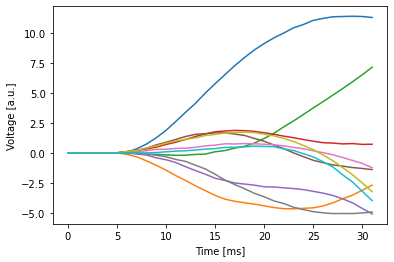

In [23]:
trained_snn = model.snn.cpu()

trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

## Network with Spike Latency Encoding

As we've mentioned above there are alternative ways of encoding and decoding the data to and from spikes. Here we go through two such alternative with the same network we've used before.


In [24]:
T = 72
DEVICE = torch.device("cuda")
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

model = Model(
    encoder=SpikeLatencyLIFEncoder(T),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): SpikeLatencyLIFEncoder()
  (snn): SNN(
    (l1): LIFCell(784, 100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=0.5, v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LIFeedForwardCell()
  )
)

In [25]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)       
    print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)

100%|██████████| 235/235 [00:35<00:00,  6.65it/s]


epoch: 0, mean_loss: 0.6865385642077061, test_loss: 0.315989182806015, accuracy: 90.05


100%|██████████| 235/235 [00:36<00:00,  6.52it/s]


epoch: 1, mean_loss: 0.2811009294809179, test_loss: 0.24155631432533264, accuracy: 92.59


100%|██████████| 235/235 [00:34<00:00,  6.72it/s]


epoch: 2, mean_loss: 0.22609294836825514, test_loss: 0.2284870018005371, accuracy: 92.77


100%|██████████| 235/235 [00:35<00:00,  6.54it/s]


epoch: 3, mean_loss: 0.19838923888003573, test_loss: 0.19805206127166747, accuracy: 93.77


100%|██████████| 235/235 [00:36<00:00,  6.51it/s]


epoch: 4, mean_loss: 0.17226314931473832, test_loss: 0.173468656873703, accuracy: 94.61


100%|██████████| 235/235 [00:35<00:00,  6.61it/s]


epoch: 5, mean_loss: 0.1580567276541223, test_loss: 0.1726443775177002, accuracy: 94.69


100%|██████████| 235/235 [00:36<00:00,  6.40it/s]


epoch: 6, mean_loss: 0.14425659648915554, test_loss: 0.16454401540756225, accuracy: 95.02


100%|██████████| 235/235 [00:36<00:00,  6.46it/s]


epoch: 7, mean_loss: 0.13285450363095772, test_loss: 0.1533120174884796, accuracy: 95.25


100%|██████████| 235/235 [00:35<00:00,  6.59it/s]


epoch: 8, mean_loss: 0.1265680486217458, test_loss: 0.14508746218681334, accuracy: 95.36


100%|██████████| 235/235 [00:36<00:00,  6.45it/s]


epoch: 9, mean_loss: 0.1161376194751009, test_loss: 0.15034738030433656, accuracy: 95.49


100%|██████████| 235/235 [00:36<00:00,  6.48it/s]


epoch: 10, mean_loss: 0.10884142495850299, test_loss: 0.14983207292556763, accuracy: 95.27


100%|██████████| 235/235 [00:36<00:00,  6.43it/s]


epoch: 11, mean_loss: 0.10601508546065777, test_loss: 0.13794725279808046, accuracy: 95.87


100%|██████████| 235/235 [00:36<00:00,  6.50it/s]


epoch: 12, mean_loss: 0.09711462796685544, test_loss: 0.14545093655586241, accuracy: 95.47


100%|██████████| 235/235 [00:37<00:00,  6.27it/s]


epoch: 13, mean_loss: 0.09372787099093832, test_loss: 0.1399221064567566, accuracy: 95.73


100%|██████████| 235/235 [00:37<00:00,  6.30it/s]


epoch: 14, mean_loss: 0.08679927004144547, test_loss: 0.15686424307823182, accuracy: 95.39


100%|██████████| 235/235 [00:39<00:00,  5.88it/s]


epoch: 15, mean_loss: 0.08247322769082607, test_loss: 0.13542270126342773, accuracy: 96.07


100%|██████████| 235/235 [00:38<00:00,  6.17it/s]


epoch: 16, mean_loss: 0.07781279500019044, test_loss: 0.1302123960018158, accuracy: 96.09


100%|██████████| 235/235 [00:39<00:00,  5.95it/s]


epoch: 17, mean_loss: 0.07481779793792583, test_loss: 0.13163357381820678, accuracy: 95.96


100%|██████████| 235/235 [00:36<00:00,  6.42it/s]


epoch: 18, mean_loss: 0.07380657806358439, test_loss: 0.13201880803108215, accuracy: 96.02


100%|██████████| 235/235 [00:38<00:00,  6.15it/s]


epoch: 19, mean_loss: 0.06885523991064822, test_loss: 0.1369179557800293, accuracy: 96.06


## Network with Poisson Encoded Input



In [26]:
T = 32
DEVICE = torch.device("cuda")
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

model = Model(
    encoder=PoissonEncoder(T, f_max=20),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): PoissonEncoder()
  (snn): SNN(
    (l1): LIFCell(784, 100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=0.5, v_reset=tensor(0.), method='super', alpha=100), dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LIFeedForwardCell()
  )
)

In [27]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)       
    print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)

100%|██████████| 235/235 [00:16<00:00, 14.47it/s]


epoch: 0, mean_loss: 0.7950868156362088, test_loss: 0.41891088380813596, accuracy: 87.34


100%|██████████| 235/235 [00:16<00:00, 14.36it/s]


epoch: 1, mean_loss: 0.40986613098611224, test_loss: 0.3514896029949188, accuracy: 88.86


100%|██████████| 235/235 [00:17<00:00, 13.65it/s]


epoch: 2, mean_loss: 0.3523987560830218, test_loss: 0.33098389077186585, accuracy: 89.62


100%|██████████| 235/235 [00:15<00:00, 14.71it/s]


epoch: 3, mean_loss: 0.32199368686118024, test_loss: 0.33899948468208313, accuracy: 89.13


100%|██████████| 235/235 [00:16<00:00, 13.97it/s]


epoch: 4, mean_loss: 0.31028435940438126, test_loss: 0.314539230632782, accuracy: 89.98


100%|██████████| 235/235 [00:15<00:00, 14.87it/s]


epoch: 5, mean_loss: 0.29041568719326183, test_loss: 0.2697485357284546, accuracy: 91.46


100%|██████████| 235/235 [00:17<00:00, 13.21it/s]


epoch: 6, mean_loss: 0.2781082934521614, test_loss: 0.25636640672683714, accuracy: 91.91


100%|██████████| 235/235 [00:17<00:00, 13.74it/s]


epoch: 7, mean_loss: 0.2643846421799761, test_loss: 0.25220004057884216, accuracy: 91.87


100%|██████████| 235/235 [00:18<00:00, 12.49it/s]


epoch: 8, mean_loss: 0.2539437031492274, test_loss: 0.25021779656410215, accuracy: 92.04


100%|██████████| 235/235 [00:18<00:00, 12.80it/s]


epoch: 9, mean_loss: 0.24180304370027908, test_loss: 0.23827064933776856, accuracy: 92.53


100%|██████████| 235/235 [00:17<00:00, 13.55it/s]


epoch: 10, mean_loss: 0.2329832785307093, test_loss: 0.22681263647079467, accuracy: 92.82


100%|██████████| 235/235 [00:17<00:00, 13.74it/s]


epoch: 11, mean_loss: 0.22933019621575132, test_loss: 0.23045039110183715, accuracy: 92.62


100%|██████████| 235/235 [00:15<00:00, 14.95it/s]


epoch: 12, mean_loss: 0.2219085066559467, test_loss: 0.2306313503265381, accuracy: 92.59


100%|██████████| 235/235 [00:15<00:00, 15.06it/s]


epoch: 13, mean_loss: 0.22428876966872113, test_loss: 0.22556425056457519, accuracy: 93.0


100%|██████████| 235/235 [00:16<00:00, 14.03it/s]


epoch: 14, mean_loss: 0.2127923436938448, test_loss: 0.2249651894569397, accuracy: 92.63


100%|██████████| 235/235 [00:15<00:00, 15.28it/s]


epoch: 15, mean_loss: 0.20818373595780515, test_loss: 0.2083357720375061, accuracy: 93.22


100%|██████████| 235/235 [00:17<00:00, 13.78it/s]


epoch: 16, mean_loss: 0.20244369972893533, test_loss: 0.2006153405189514, accuracy: 93.28


100%|██████████| 235/235 [00:15<00:00, 14.72it/s]


epoch: 17, mean_loss: 0.19761329911490705, test_loss: 0.20033579874038696, accuracy: 93.93


100%|██████████| 235/235 [00:15<00:00, 15.10it/s]


epoch: 18, mean_loss: 0.1931004674193707, test_loss: 0.19815179920196532, accuracy: 94.04


100%|██████████| 235/235 [00:17<00:00, 13.73it/s]


epoch: 19, mean_loss: 0.1852059375415457, test_loss: 0.19197875833511352, accuracy: 93.92


As can be seen from the training result, this combination of hyperparameters, decoding and encoding scheme performs worse than the alternative we've presented before. As with any machine learning approach one of the biggest challenges is to find a combination of these choices that works well. Sometimes theoretical knowledge helps in making these choices. For example it is well known that poisson encoded input will converge with $1/\sqrt{T}$, where $T$ is the number of timesteps. So most likely the low number of timesteps ($T = 32$) contributes to the poor performance.

In the next section we will see that choice of network architecture is also key in training performant spiking neural networks, just as it is for artifiicial neural networks.

## Convolutional Networks

The simple two layer recurrent spiking neural network we've defined above achieves a respectable ~96.5% accuracy after 10 training epochs. One common way
to improve on this performance is to use convolutional neural networks. We define here two convolutional layers and one spiking classification layer. Just as in the recurrent spiking neural network before, we use a non-spiking leaky integrator for readout.

The ```torch.nn.functional.max_pool2d``` on binary values is a logical ```or``` operation on its inputs. 


In [28]:
from norse.torch.module.leaky_integrator import LICell
from norse.torch.functional.lif import LIFFeedForwardState
from norse.torch.functional.leaky_integrator import LIState

from typing import NamedTuple

class ConvNetState(NamedTuple):
    lif0 : LIFFeedForwardState
    lif1 : LIFFeedForwardState
    lif2 : LIFFeedForwardState
    readout : LIState



class ConvNet(torch.nn.Module):
    def __init__(
        self,  num_channels=1, feature_size=28, method="super", alpha=100, record=False
    ):
        super(ConvNet, self).__init__()

        self.record = record
        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500)
        self.lif0 = LIFFeedForwardCell(
            (20, feature_size - 4, feature_size - 4),
            p=LIFParameters(method=method, alpha=alpha),
        )
        self.lif1 = LIFFeedForwardCell(
            (50, int((feature_size - 4) / 2) - 4, int((feature_size - 4) / 2) - 4),
            p=LIFParameters(method=method, alpha=alpha),
        )
        self.lif2 = LIFFeedForwardCell(
            (500,), p=LIFParameters(method=method, alpha=alpha)
        )
        self.out = LICell(500, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]
        
        # specify the initial states
        s0 = self.lif0.initial_state(batch_size, device=x.device, dtype=x.dtype)
        s1 = self.lif1.initial_state(batch_size, device=x.device, dtype=x.dtype)
        s2 = self.lif2.initial_state(batch_size, device=x.device, dtype=x.dtype)
        so = self.out.initial_state(device=x.device, dtype=x.dtype)

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        if self.record:
          self.recording += ConvNetState(s0, s1, s2, so)
        
        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, 4 ** 2 * 50)
            z = self.fc1(z)        
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

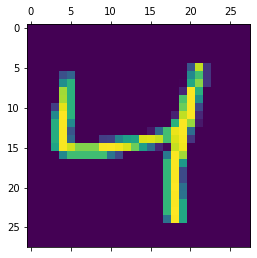

4


In [29]:
img, label = train_data[2]

plt.matshow(img[0])
plt.show()
print(label)

Just as we did we can visualise the output of the untrained convolutional network on a sample input. Notice that compared to the previous untrained
output the first non-zero membrane trace values appear later. This is due to 
the fact that there is a finite delay for each added layer in the network. 

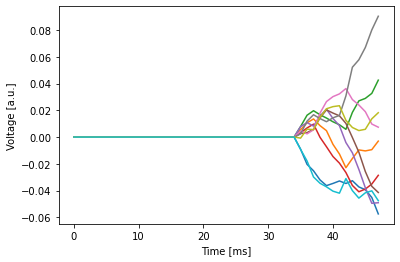

In [30]:
T = 48
example_encoder = ConstantCurrentLIFEncoder(T)
example_input = example_encoder(img)
example_snn = ConvNet()
example_readout_voltages = example_snn(example_input.unsqueeze(1))

plt.plot(example_readout_voltages.squeeze(1).detach().numpy())
plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

In [31]:
T = 48
DEVICE = torch.device("cuda")
LR = 0.001
EPOCHS = 20

model = Model(
    encoder=ConstantCurrentLIFEncoder(T),
    snn=ConvNet(alpha=80),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): ConvNet(
    (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=800, out_features=500, bias=True)
    (lif0): LIFFeedForwardCell((20, 24, 24), p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=80), dt=0.001)
    (lif1): LIFFeedForwardCell((50, 8, 8), p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=80), dt=0.001)
    (lif2): LIFFeedForwardCell((500,), p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=80), dt=0.001)
    (out): LICell()
  )
)

In [32]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

for epoch in range(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)       
    print(f"epoch: {epoch}, mean_loss: {mean_loss}, test_loss: {test_loss}, accuracy: {accuracy}", flush=True)

100%|██████████| 235/235 [02:52<00:00,  1.36it/s]


epoch: 0, mean_loss: 0.40599232577580086, test_loss: 0.0972125952243805, accuracy: 97.17


100%|██████████| 235/235 [02:56<00:00,  1.33it/s]


epoch: 1, mean_loss: 0.07718884139618976, test_loss: 0.05550244588851929, accuracy: 98.32


100%|██████████| 235/235 [02:57<00:00,  1.32it/s]


epoch: 2, mean_loss: 0.05674585003326548, test_loss: 0.04144481511116028, accuracy: 98.62


100%|██████████| 235/235 [02:58<00:00,  1.32it/s]


epoch: 3, mean_loss: 0.047182296541460014, test_loss: 0.04509100160598755, accuracy: 98.58


100%|██████████| 235/235 [02:58<00:00,  1.31it/s]


epoch: 4, mean_loss: 0.04001047902324415, test_loss: 0.035797838497161866, accuracy: 98.94


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 5, mean_loss: 0.03321082960180145, test_loss: 0.032592955541610714, accuracy: 99.0


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 6, mean_loss: 0.031028201664857407, test_loss: 0.03270032114982605, accuracy: 98.95


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


epoch: 7, mean_loss: 0.027873838498712854, test_loss: 0.030764342117309572, accuracy: 99.05


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 8, mean_loss: 0.024972189217805862, test_loss: 0.03288957672119141, accuracy: 98.91


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 9, mean_loss: 0.02256547576014666, test_loss: 0.029784456539154052, accuracy: 99.01


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


epoch: 10, mean_loss: 0.02041002927110233, test_loss: 0.028808069753646852, accuracy: 99.01


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


epoch: 11, mean_loss: 0.019341098846114697, test_loss: 0.031254805707931516, accuracy: 99.01


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


epoch: 12, mean_loss: 0.018743261116299224, test_loss: 0.031553656101226804, accuracy: 99.1


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 13, mean_loss: 0.018566582567910564, test_loss: 0.03260271544456482, accuracy: 98.92


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 14, mean_loss: 0.014821379881431448, test_loss: 0.03065118546485901, accuracy: 98.99


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 15, mean_loss: 0.0139283155150553, test_loss: 0.03058469624519348, accuracy: 98.97


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 16, mean_loss: 0.013341504999218469, test_loss: 0.02722659547328949, accuracy: 99.04


100%|██████████| 235/235 [02:59<00:00,  1.31it/s]


epoch: 17, mean_loss: 0.012718240783470584, test_loss: 0.027996623277664185, accuracy: 99.06


100%|██████████| 235/235 [03:00<00:00,  1.30it/s]


epoch: 18, mean_loss: 0.011122116260230542, test_loss: 0.031265582942962646, accuracy: 99.07


100%|██████████| 235/235 [03:01<00:00,  1.30it/s]


epoch: 19, mean_loss: 0.00970187763425898, test_loss: 0.029469941234588622, accuracy: 99.12


torch.Size([48, 1, 10])


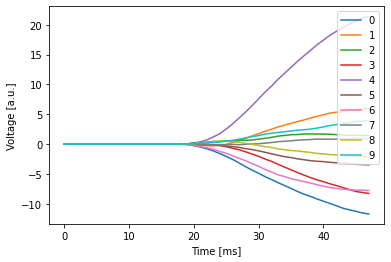

In [33]:
trained_snn = model.snn.cpu()

trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
  plt.plot(trained_readout_voltages[:,:,i].squeeze(1).detach().numpy(), label=f'{i}')

plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.legend()
plt.show()

As we can see the output neuron for the label '4' indeed integrates
the largest number of spikes.

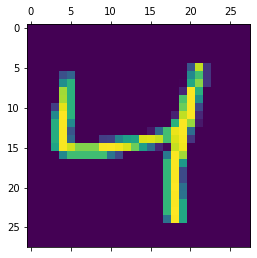

In [34]:
plt.matshow(np.squeeze(img,0))

## Conclusions

We've seen that on a small supervised learning task it is relatively easy to define spiking neural networks that perform about as well as non-spiking artificial networks. The network architecture used is in direct correspondence to one that would be used to solve such a task with an artificial neural network, with the non-linearities replaced by spiking units. 

The remaining difference in performance might be related to a number of choices:
- hyperparameters of the optimizer
- precise architecture (e.g. dimensionality of the classification layer)
- weight initialisation
- decoding scheme
- encoding scheme
- number of integration timesteps

The first three points are in common with the problems encountered in the design and training of artificial neural network classifiers. Comparatively little is known though about their interplay for spiking neural network architectures.

The last three points are special to spiking neural network problems simply because of their constraints on what kind of data they can process naturally. While their interplay has certainly been investigated in the literature, it is unclear if there is a good answer what encoding and decoding should be chosen in general.

Finally we've also omitted any regularisation or data-augementation, which could further improve performance. Common techniques would be to introduce weight decay or penalise unbiologically high firing rates. In the simplest case those can enter as addtional terms in the loss function we've defined above.